In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook
from IPython.display import HTML
import time
import datetime
import json

#Import usual things required for graph nets
import numpy as np
import pandas as pd
import networkx as nx
import sonnet as snt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import sys

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Polygon

import seaborn as sns
from sklearn.model_selection import train_test_split

#Import graph nets
from graph_nets import blocks
from graph_nets import utils_tf
from graph_nets import utils_np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

#Set seed
SEED = 4893

np.random.seed(SEED)
rand = np.random.RandomState(SEED)
tf.random.set_seed(SEED)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Num GPUs Available:  1


In [2]:
#Path to the scripts shared troughout phases
parent_path=os.path.abspath('..\\..')
path_common =  '\\'.join(parent_path.split('\\')[:-1]) 

#Check if path exists
path_common_scripts = os.path.join(path_common,'Common','Scripts')
if(not os.path.exists(path_common_scripts)):
    print('The path: '+ path_common_scripts+' is not found!')
path_common = os.path.join(path_common,'Common')
#Check if path exists
if(not os.path.exists(path_common)):
    print('The path: '+ path_common+' is not found!')



#Add shared scripts to our current paths for importing
sys.path.insert(0, path_common_scripts)

#Retrieve test specification document
test_spec_json = os.path.join(path_common,'hyper_parameters.json')
#Check if file exists
if(not os.path.exists(test_spec_json)):
    print('The file: '+ test_spec_json+' is not found!')
with open(test_spec_json) as f:
    test_spec = json.load(f)
    
params = test_spec['parameters']

model_params = params['model_parameters']

experiment_params = params['experiment_parameters']

#Save experiment begin date
current_time = datetime.datetime.now()
print("Current_date: "+str(current_time))
current_time = "".join(current_time.strftime("%x").split('/'))

NUM_TRAINING_ITERATIONS = experiment_params['number_of_training_iterations']
LOSS_TYPE = experiment_params['loss_type']
#BATCH_SIZE_TR = experiment_params['training_batch_size']
#BATCH_SIZE_TE = experiment_params['testing_batch_size']
#BATCH_SIZE_GE = experiment_params['generalisation_batch_size']
NUM_PROCESSING_STEPS_TR = experiment_params['number_of_processing_steps_tr']
NUM_PROCESSING_STEPS_TE = experiment_params['number_of_processing_steps_te']
NUM_PROCESSING_STEPS_GE = experiment_params['number_of_processing_steps_ge']
#ROLLOUT_TIMESTEPS = experiment_params['rollout_timesteps']
#ROLLOUT_TIMESTEPS_VIS = experiment_params['rollout_timesteps_vis']

FUL_LATENT_SIZE = model_params['ful_block_latent_size']
FUL_LAYER_NUMBER = model_params['ful_block_number_of_layers']
IND_LATENT_SIZE = model_params['ind_block_latent_size']
IND_LAYER_NUMBER = model_params['ind_block_number_of_layers']

Current_date: 2021-04-24 15:52:02.753639


In [3]:
# Import model
import GNNModels_tf2 as models
# Import training plot
from TrainingPlot import training_plot, training_plot_log_scale
# Import rollout plot
from RolloutPlot import rollout_plot, rollout_plot_log_scale
# Import functions for creating graph
from Graph_creator_functions import rigid_graph_from_pos_all, rigid_graph_from_pos_closest
# Import data loader module
from PushDatasetLoad import load_dataset, collect_trajectory_indeces, create_train_valid_test, collect_states, remove_effector, outlier_remover, dataset_formating
# Import Dataset Feeder function
from PushDatasetFeed import DataFeeder
# Import simulation functions
from PushDatasetSimulator import PushDatasetSimulator
# Import function for experiments
from LossFunctions import velocity_loss_single_step, make_all_runnable_in_session, rollout_loss_mean, rollout_loss_sum, rollout_loss_max, rollout_error, rollout_error_position
# Import visualisation functions
from VisualisationFunctions import visualise_trajectory, visualise_groundtruth

## Data loading:
In this section of the code we load the data. Split the trajectories into training, validation and testing sets.

In [4]:
#Path to Datasets
path_dataset = os.path.abspath('..\\..\\..\\..\\..')
path_dataset = os.path.join(path_dataset,'Data')

if(not os.path.exists(path_dataset)):
    print("Data folder does not exist.")
    
# Set paths:
file_1 = os.path.join(path_dataset, "Rect1_Data10ms_1_of_2_flagged.csv")
file_2 = os.path.join(path_dataset, "Rect1_Data10ms_2_of_2_flagged.csv")
# Load dataset
df_set_1, STEP_SIZE = load_dataset(file_1)
df_set_2, STEP_SIZE = load_dataset(file_2)

# Collect trajectory indeces
VEL_ACCS = ['10.0-0.0',
            '20.0-0.0',
            '50.0-0.0', 
            '75.0-0.0']
trajectory_indeces,df_set_1 = collect_trajectory_indeces(df_set_1, ts = STEP_SIZE, vel_accs = VEL_ACCS)

_, df_set_2 = collect_trajectory_indeces(df_set_2, ts = STEP_SIZE, vel_accs = VEL_ACCS)
# Split indeces so that no trajectory is contained in both train, validation or test datasets
tr_inds, va_inds, te_inds = create_train_valid_test(trajectory_indeces, 0.20)

# Collect trajectories from these 
df_tr_1 = collect_states(tr_inds, df_set_1)
df_tr_2 = collect_states(tr_inds, df_set_2)
df_va_1 = collect_states(va_inds, df_set_1)
df_va_2 = collect_states(va_inds, df_set_2)
df_te_1 = collect_states(te_inds, df_set_1)
df_te_2 = collect_states(te_inds, df_set_2)

# Remove Outliers
STATIONARY_THRESHOLD =  0.001
df_tr_1, df_tr_2 = outlier_remover(df_tr_1, df_tr_2, STATIONARY_THRESHOLD)
df_va_1, df_va_2 = outlier_remover(df_va_1, df_va_2, STATIONARY_THRESHOLD)
df_te_1, df_te_2 = outlier_remover(df_te_1, df_te_2, STATIONARY_THRESHOLD)

min_roll_tr, max_batch_tr, df_tr_1, df_tr_2 = dataset_formating(df_tr_1,df_tr_2)
min_roll_te, max_batch_te, df_te_1, df_te_2 = dataset_formating(df_te_1,df_te_2)
min_roll_va, max_batch_va, df_va_1, df_va_2 = dataset_formating(df_va_1,df_va_2)

print("Tr","Min rollout step number: ", min_roll_tr, ", Max batch size: ",max_batch_tr)
print("Te","Min rollout step number: ", min_roll_te, ", Max batch size: ",max_batch_te)
print("Va","Min rollout step number: ", min_roll_va, ", Max batch size: ",max_batch_va)

BATCH_SIZE_TR = int(max_batch_tr / 4)
BATCH_SIZE_GE = int(max_batch_va) 
BATCH_SIZE_TE = int(max_batch_te)

ROLLOUT_TIMESTEPS = int(min(min_roll_tr,min_roll_te, min_roll_va)/5)
ROLLOUT_TIMESTEPS_GE = int(min_roll_va)
ROLLOUT_TIMESTEPS_TE = int(min_roll_te)

ROLLOUT_TIMESTEPS= 18
print("Tr","Batch Size: ", BATCH_SIZE_TR, ", Rollout length: ",ROLLOUT_TIMESTEPS)
print("Va","Batch Size: ", BATCH_SIZE_GE, ", Rollout length: ",ROLLOUT_TIMESTEPS_GE)
print("Te","Batch Size: ", BATCH_SIZE_TE, ", Rollout length: ",ROLLOUT_TIMESTEPS_TE)

df_dict = {"tr_1":df_tr_1, 
           "tr_2":df_tr_2, 
           "va_1":df_va_1,
           "va_2":df_va_2,
           "te_1":df_te_1,
           "te_2":df_te_2,}

Tr Min rollout step number:  97.0 , Max batch size:  252
Te Min rollout step number:  91.0 , Max batch size:  37
Va Min rollout step number:  90.0 , Max batch size:  24
Tr Batch Size:  63 , Rollout length:  18
Va Batch Size:  24 , Rollout length:  90
Te Batch Size:  37 , Rollout length:  91


In [5]:
# Folder description to distinguish between experiment runs
desc = "ntr"+str(NUM_TRAINING_ITERATIONS)
desc = desc +"_d"+str(FUL_LAYER_NUMBER)
desc = desc +"l"+str(FUL_LATENT_SIZE)
desc = desc +"d"+str(IND_LAYER_NUMBER)
desc = desc +"l"+str(IND_LATENT_SIZE)
desc = desc +"_ss"+str(STEP_SIZE).split(".")[1]
desc = desc +"_nb"+str(BATCH_SIZE_TR)
desc = desc +"_nr"+str(ROLLOUT_TIMESTEPS)
desc = desc +"_vs"

#for i in range(len(VEL_ACCS)):
#    v = VEL_ACCS[i].split("-")[0].split(".")[0]
#    if i == len(VEL_ACCS)-1:
#        desc = desc + v
#    else:
#        desc = desc + v + "-"
        
desc = desc +"_lt" +str(LOSS_TYPE)[0]
desc = desc +"_da"+str(current_time)
desc = desc +"_se"+str(SEED)

In [6]:
# Setup folders
base = os.getcwd()
if(not os.path.exists(base)):
    os.makedirs(base)
    
#Path to saved models and trajectories
path_saves = os.path.join(base,desc,'Saves')
if(not os.path.exists(path_saves)):
    os.makedirs(path_saves)
    
#Path to plots
path_plots = os.path.join(base,desc,'Plots')
if(not os.path.exists(path_plots)):
    os.makedirs(path_plots)
    
#Path to animations
path_animations = os.path.join(base,desc,'Animations')
if(not os.path.exists(path_animations)):
    os.makedirs(path_animations)
    
#Save the used parameters as a json file into this folder
with open(os.path.join(path_saves,'specification.json'), 'w') as fp:
    json.dump(test_spec, fp)

# Train

In [7]:
# Create the model.
model = models.EncodeProcessDecode(ind_layer_numbers = IND_LAYER_NUMBER,
                                   ind_latent_unit_size = IND_LATENT_SIZE,
                                   ful_layer_numbers = FUL_LAYER_NUMBER,
                                   ful_latent_unit_size = FUL_LATENT_SIZE,
                                   node_output_size=2,
                                   edge_output_size=2,
                                   global_output_size=1)



LEARNING_RATE = model_params['learning_rate']
optimizer = snt.optimizers.Adam(0.0002)

In [8]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
path_ckpts = os.path.join(path_saves,'tf_ckpts')
manager = tf.train.CheckpointManager(ckpt, path_ckpts, max_to_keep=3)

if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [9]:
def update_step(inputs_tr, targets_tr):
    with tf.GradientTape() as tape:
        outputs_tr = model(inputs_tr, 1)
        # Only Nodes
        outputs_tr_nodes = outputs_tr[0].nodes
        targets_tr_nodes = targets_tr.nodes
        # Loss
        loss_tr = velocity_loss_single_step(targets_tr, outputs_tr[0])
    
    gradients = tape.gradient(loss_tr, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)
    return outputs_tr, loss_tr, gradients

def test_step(inputs, targets):
    outputs = model(inputs, 1)
    # Only Nodes
    output_nodes = outputs[0].nodes
    target_nodes = targets.nodes
    
    # Loss
    loss = velocity_loss_single_step(targets, outputs[0])
    
    return loss


def update_step_rollout(inputs_tr, targets_tr):
    with tf.GradientTape() as tape:
        # Predict trajectory using the model
        pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, inputs_tr, targets_tr)
        # Loss tr
        loss_tr = rollout_loss_mean(real_trajectory, pred_trajectory)
        
    gradients = tape.gradient(loss_tr, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)
    return 0, loss_tr, gradients

def test_step_rollout(inputs, targets, sim):
    # Predict trajectory using the model
    pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, inputs, targets)
    
    # Loss
    loss = rollout_loss_mean(real_trajectory, pred_trajectory)
                        
    return loss


## Compiling loss function

In [10]:
# Setup data feeder and simulator

# One step data feeder
feeder = DataFeeder(SEED)
d = feeder.get_data(dfs = df_dict,
                    tr_batch_size = BATCH_SIZE_TR,
                    va_batch_size = BATCH_SIZE_GE,
                    te_batch_size = BATCH_SIZE_TE,
                    graph_creator = rigid_graph_from_pos_all)

# Rollout simulator feeder
sim = PushDatasetSimulator(rollout_steps = ROLLOUT_TIMESTEPS, 
                           step_size = STEP_SIZE)

sim_te = PushDatasetSimulator(rollout_steps = min(ROLLOUT_TIMESTEPS_GE, ROLLOUT_TIMESTEPS_TE), 
                           step_size = STEP_SIZE)
# ------------------------------------------------------------------------

# Get data from feeder
X_tr_step = d["X_tr"]
Y_tr_step = d["Y_tr"]

# Get data from simulator
real, pred, i_np, _ = sim.get_trajectories(df_tr_1, df_tr_2, BATCH_SIZE_TR, rigid_graph_from_pos_all)
X_tr_roll, Y_tr_roll = sim.convert_trajectories(real, pred)

# ------------------------------------------------------------------------

# Get input signature of one step input
input_signature_step = [
    utils_tf.specs_from_graphs_tuple(X_tr_step),
    utils_tf.specs_from_graphs_tuple(X_tr_step)]

# Get input signature of rollout input
input_signature_rollout = [
    [utils_tf.specs_from_graphs_tuple(X_tr_roll[0])]*ROLLOUT_TIMESTEPS,
    [utils_tf.specs_from_graphs_tuple(Y_tr_roll[0])]*ROLLOUT_TIMESTEPS]

# ------------------------------------------------------------------------

# Compile the update function using the input signature for speedy code
compiled_update_step = tf.function(update_step, input_signature = input_signature_step)
compiled_update_step_rollout = tf.function(update_step_rollout, input_signature = input_signature_rollout)

In [11]:
tf.config.run_functions_eagerly(False)
# Setup logging
last_iteration = 0
logged_iterations = []
losses_step_tr = []
losses_step_va = []
losses_step_te = []

losses_roll_tr = []
losses_roll_va = []
losses_roll_te = []
gradients = []

log_every_iteration = 10

print("# (iteration number) out of max iteration, T (elapsed seconds), "
      "Ltr, "
      "Lte, "
      "Lge")

start_time = time.time()
last_log_time = start_time


best_loss = 1000
 
for iteration in range(last_iteration, NUM_TRAINING_ITERATIONS):
    last_iteration = iteration
    do_logging = (last_iteration % log_every_iteration == 0)
    
    loss_roll_tr = tf.constant([0])
    loss_step_tr = tf.constant([0])
    gradient = tf.constant([0])
    
    if LOSS_TYPE == "rollout":
        # Get training data: Rollout
        real_tr, pred_tr, i_np, _ = sim.get_trajectories(df_tr_1, df_tr_2, BATCH_SIZE_TR, rigid_graph_from_pos_all)
        X_roll_tr, Y_roll_tr = sim.convert_trajectories(real_tr, pred_tr)

        X_step_tr = X_roll_tr[0]
        Y_step_tr = Y_roll_tr[0]   
        # Training:  One-step
        loss_step_tr = test_step(X_step_tr, Y_step_tr)
        # Do one tick of training    
        outputs_tr, loss_roll_tr, gradient = compiled_update_step_rollout(X_roll_tr, Y_roll_tr)
        
    elif LOSS_TYPE == "step":
        d = feeder.get_data(dfs = df_dict,
                    tr_batch_size = BATCH_SIZE_TR,
                    va_batch_size = BATCH_SIZE_GE,
                    te_batch_size = BATCH_SIZE_TE,
                    graph_creator = rigid_graph_from_pos_all,
                    te_and_va = False)
        
        # Get data from feeder
        X_step_tr = d["X_tr"]
        Y_step_tr = d["Y_tr"]

        # Do one tick of training    
        outputs_tr, loss_step_tr, gradient = compiled_update_step(X_step_tr, Y_step_tr)
        
    else:
        # Get training data: Rollout
        real_tr, pred_tr, i_np, _ = sim.get_trajectories(df_tr_1, df_tr_2, BATCH_SIZE_TR, rigid_graph_from_pos_all)
        X_roll_tr, Y_roll_tr = sim.convert_trajectories(real_tr, pred_tr)

        X_step_tr = X_roll_tr[0]
        Y_step_tr = Y_roll_tr[0]   
        # Training:  Rollout
        loss_roll_tr = test_step_rollout(X_roll_tr, Y_roll_tr, sim)
        # Do one tick of training    
        outputs_tr, loss_step_tr, gradient = compiled_update_step(X_step_tr, Y_step_tr)
    
    
    ckpt.step.assign_add(1)
    # Don't log at every iteration
    if do_logging:
        # Get validation and test data: Rollout
        real_va, pred_va, _ , _ = sim.get_trajectories(df_va_1, df_va_2, BATCH_SIZE_GE, rigid_graph_from_pos_all)
        X_roll_va, Y_roll_va = sim.convert_trajectories(real_va, pred_va)
        real_te, pred_te, _ , _ = sim.get_trajectories(df_te_1, df_te_2, BATCH_SIZE_TE, rigid_graph_from_pos_all)
        X_roll_te, Y_roll_te = sim.convert_trajectories(real_te, pred_te)
        
        # Get validation and test data: One-step
        X_step_va = X_roll_va[0]
        Y_step_va = Y_roll_va[0]
        X_step_te = X_roll_te[0]
        Y_step_te = Y_roll_te[0]      
        
        # Validation and Test: Rollout
        loss_roll_va = test_step_rollout(X_roll_va, Y_roll_va, sim_te)
        loss_roll_te = test_step_rollout(X_roll_te, Y_roll_te, sim_te)
        
        # Validation and Test: One-step
        loss_step_va = test_step(X_step_va, Y_step_va)
        loss_step_te = test_step(X_step_te, Y_step_te)
        
        # Convert losses to normal values
        loss_roll_tr = loss_roll_tr[0].numpy()
        loss_roll_va = loss_roll_va[0].numpy()
        loss_roll_te = loss_roll_te[0].numpy()
        loss_step_tr = loss_step_tr[0].numpy()
        loss_step_va = loss_step_va[0].numpy()
        loss_step_te = loss_step_te[0].numpy()
        
        the_time = time.time()
        elapsed_since_last_log = the_time - last_log_time
        last_log_time = the_time
        
        # Save
        if best_loss > loss_step_va:
            save_path = manager.save()
            print("Saved checkpoint for step {}".format(int(ckpt.step)))
            best_loss = loss_step_va.copy()
        
        # Log data
        elapsed = time.time() - start_time
        losses_roll_tr.append(loss_roll_tr)
        losses_roll_va.append(loss_roll_va)
        losses_roll_te.append(loss_roll_te)
        
        losses_step_tr.append(loss_step_tr)
        losses_step_va.append(loss_step_va)
        losses_step_te.append(loss_step_te)
        
        gradients.append(gradient)
        logged_iterations.append(iteration)
        
        
        print("# {:05d}, Max {:05d}, T {:.1f}, Ltr Step {:.6f}, Lva Step {:.6f}, Lte Step {:.6f}".format(
            iteration, NUM_TRAINING_ITERATIONS, elapsed, loss_step_tr, loss_step_va, loss_step_te))
        print("# {:05d}, Max {:05d}, T {:.1f}, Ltr Roll {:.6f}, Lva Roll {:.6f}, Lte Roll {:.6f}".format(
            iteration, NUM_TRAINING_ITERATIONS, elapsed, loss_roll_tr, loss_roll_va, loss_roll_te))
        print("-----------------------------------------------------------------------------------")
    
tf.config.run_functions_eagerly(True)    

# (iteration number) out of max iteration, T (elapsed seconds), Ltr, Lte, Lge


C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges_17/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges_17/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges_17/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape

C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges_11/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges_11/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges_11/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape

C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges_5/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges_5/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges_5/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/En

Saved checkpoint for step 2
# 00000, Max 01000, T 57.0, Ltr Step 0.720573, Lva Step 3.961111, Lte Step 4.020908
# 00000, Max 01000, T 57.0, Ltr Roll 0.260584, Lva Roll 1.233533, Lte Roll 1.258865
-----------------------------------------------------------------------------------
Saved checkpoint for step 12
# 00010, Max 01000, T 82.6, Ltr Step 3.630195, Lva Step 3.509787, Lte Step 3.621400
# 00010, Max 01000, T 82.6, Ltr Roll 1.024525, Lva Roll 0.854805, Lte Roll 0.888543
-----------------------------------------------------------------------------------
Saved checkpoint for step 22
# 00020, Max 01000, T 109.0, Ltr Step 2.201544, Lva Step 2.117881, Lte Step 2.109629
# 00020, Max 01000, T 109.0, Ltr Roll 0.436290, Lva Roll 0.426040, Lte Roll 0.436414
-----------------------------------------------------------------------------------
Saved checkpoint for step 32
# 00030, Max 01000, T 134.4, Ltr Step 0.844747, Lva Step 0.685450, Lte Step 0.763929
# 00030, Max 01000, T 134.4, Ltr Roll 0.17

# 00320, Max 01000, T 856.8, Ltr Step 0.084048, Lva Step 0.092437, Lte Step 0.068429
# 00320, Max 01000, T 856.8, Ltr Roll 0.003661, Lva Roll 0.002796, Lte Roll 0.003449
-----------------------------------------------------------------------------------
# 00330, Max 01000, T 882.2, Ltr Step 0.092673, Lva Step 0.098757, Lte Step 0.071649
# 00330, Max 01000, T 882.2, Ltr Roll 0.004001, Lva Roll 0.002326, Lte Roll 0.003009
-----------------------------------------------------------------------------------
# 00340, Max 01000, T 906.8, Ltr Step 0.083738, Lva Step 0.102139, Lte Step 0.073003
# 00340, Max 01000, T 906.8, Ltr Roll 0.003806, Lva Roll 0.003043, Lte Roll 0.002761
-----------------------------------------------------------------------------------
# 00350, Max 01000, T 931.4, Ltr Step 0.093726, Lva Step 0.102747, Lte Step 0.067847
# 00350, Max 01000, T 931.4, Ltr Roll 0.003661, Lva Roll 0.002108, Lte Roll 0.003177
--------------------------------------------------------------------

# 00640, Max 01000, T 1650.7, Ltr Step 0.093172, Lva Step 0.088871, Lte Step 0.086744
# 00640, Max 01000, T 1650.7, Ltr Roll 0.003543, Lva Roll 0.002453, Lte Roll 0.003132
-----------------------------------------------------------------------------------
# 00650, Max 01000, T 1675.4, Ltr Step 0.091616, Lva Step 0.105499, Lte Step 0.066853
# 00650, Max 01000, T 1675.4, Ltr Roll 0.002636, Lva Roll 0.002496, Lte Roll 0.002981
-----------------------------------------------------------------------------------
# 00660, Max 01000, T 1700.2, Ltr Step 0.093135, Lva Step 0.098324, Lte Step 0.064475
# 00660, Max 01000, T 1700.2, Ltr Roll 0.002781, Lva Roll 0.002891, Lte Roll 0.002793
-----------------------------------------------------------------------------------
# 00670, Max 01000, T 1725.1, Ltr Step 0.096292, Lva Step 0.087501, Lte Step 0.079260
# 00670, Max 01000, T 1725.1, Ltr Roll 0.003224, Lva Roll 0.002167, Lte Roll 0.002883
------------------------------------------------------------

# 00960, Max 01000, T 2446.6, Ltr Step 0.096395, Lva Step 0.100276, Lte Step 0.073139
# 00960, Max 01000, T 2446.6, Ltr Roll 0.002528, Lva Roll 0.003074, Lte Roll 0.002717
-----------------------------------------------------------------------------------
# 00970, Max 01000, T 2471.3, Ltr Step 0.090169, Lva Step 0.085886, Lte Step 0.073543
# 00970, Max 01000, T 2471.3, Ltr Roll 0.003257, Lva Roll 0.001953, Lte Roll 0.002632
-----------------------------------------------------------------------------------
# 00980, Max 01000, T 2496.2, Ltr Step 0.093259, Lva Step 0.094974, Lte Step 0.096848
# 00980, Max 01000, T 2496.2, Ltr Roll 0.002377, Lva Roll 0.002360, Lte Roll 0.002440
-----------------------------------------------------------------------------------
# 00990, Max 01000, T 2520.9, Ltr Step 0.090244, Lva Step 0.099560, Lte Step 0.083978
# 00990, Max 01000, T 2520.9, Ltr Roll 0.003145, Lva Roll 0.002870, Lte Roll 0.002830
------------------------------------------------------------

## Restore best model

In [12]:
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from C:\Users\vbenc\Projects\Honours\Honours3\Phases\Phase3\Ex-Roll5Vs18\O-18Roll\ntr1000_d2l256d2l256_ss01_nb63_nr18_vs_ltr_da042421_se4893\Saves\tf_ckpts\ckpt-13


## Saving losses

In [13]:
def save_data(name, data):
    data = np.array(data)
    if os.path.exists(os.path.join(path_saves, name)):
        print("The file: "+ name + " already exists. Delete it before saving a new trajectory!")
    else:
        if not os.path.exists(os.path.join(path_saves)):
            os.makedirs(os.path.join(path_saves)) 
            
        np.save(os.path.join(path_saves, name), data)

save_data("iterations", logged_iterations)
save_data("losses_step_tr", losses_step_tr)
save_data("losses_step_te", losses_step_te)
save_data("losses_step_va", losses_step_va)
save_data("losses_roll_tr", losses_roll_tr)
save_data("losses_roll_te", losses_roll_te)
save_data("losses_roll_va", losses_roll_va)
save_data("gradients", gradients)


C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


<IPython.core.display.Javascript object>


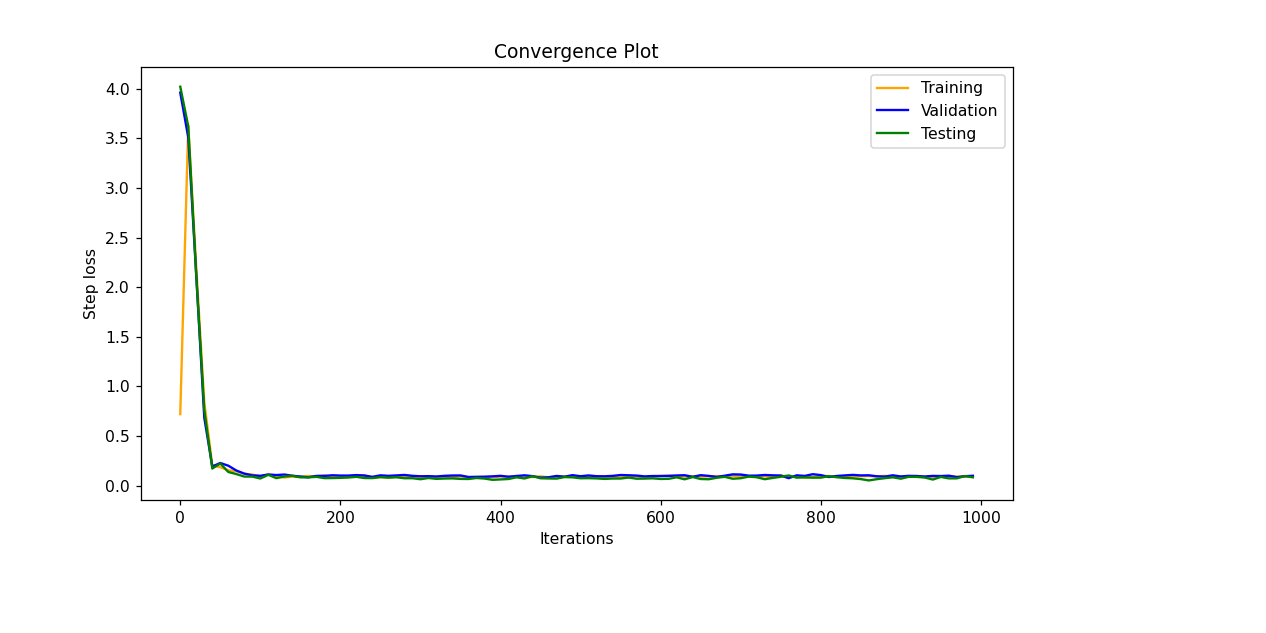

In [14]:
plt.close('all')
fig, ax = training_plot(logged_iterations, losses_step_tr, losses_step_va, losses_step_te, path_plots, loss = "Step", title = "Convergence Plot")
plt.show()

<IPython.core.display.Javascript object>


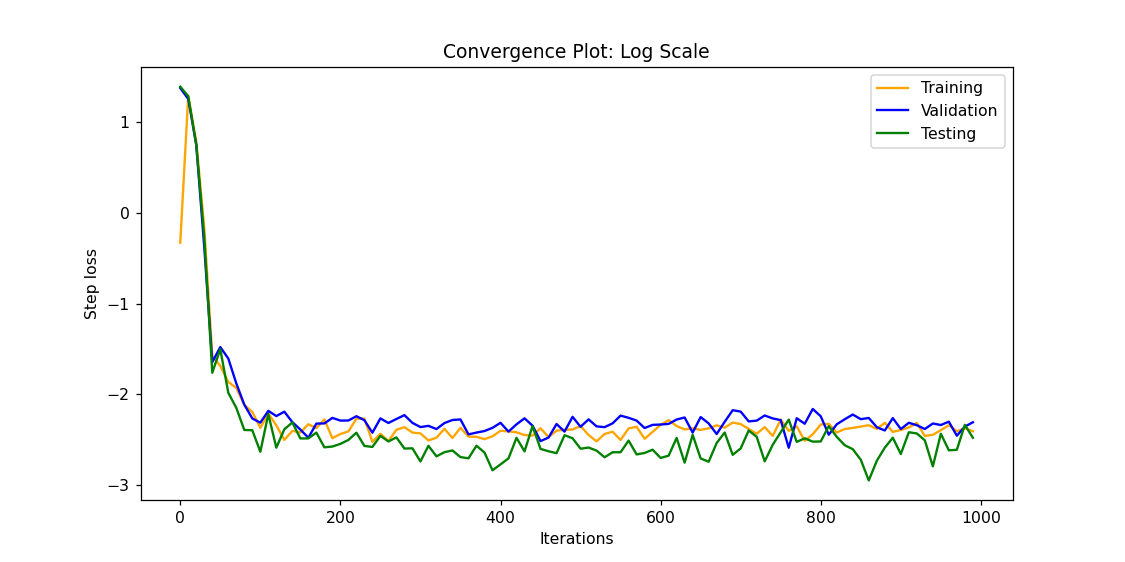

In [15]:
plt.close('all')
fig, ax = training_plot_log_scale(logged_iterations, losses_step_tr, losses_step_va, losses_step_te, path_plots, loss = "Step", title = "Convergence Plot: Log Scale")
plt.show()

<IPython.core.display.Javascript object>


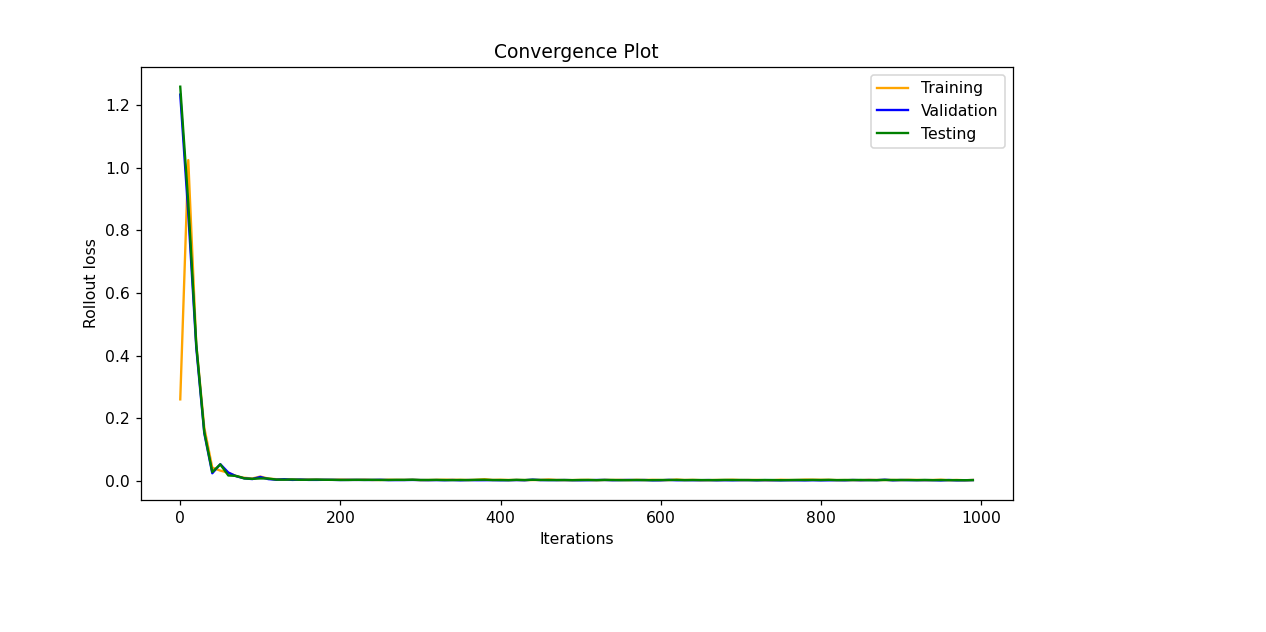

In [16]:
plt.close('all')
fig, ax = training_plot(logged_iterations, losses_roll_tr, losses_roll_va, losses_roll_te, path_plots, loss = "Rollout", title = "Convergence Plot")
plt.show()

<IPython.core.display.Javascript object>


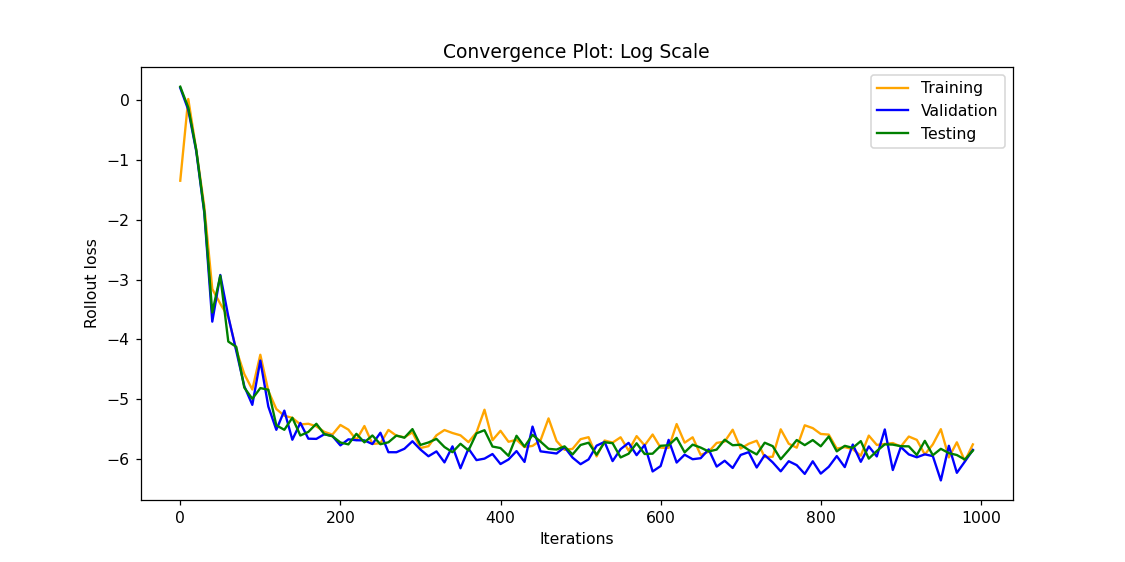

In [17]:
plt.close('all')
fig, ax = training_plot_log_scale(logged_iterations, losses_roll_tr, losses_roll_va, losses_roll_te, path_plots, loss = "Rollout", title = "Convergence Plot: Log Scale")
plt.show()

## Evaluation

In [18]:

df = df_te_1.groupby('trajectory')['id'].nunique()
df

trajectory
569.0     28
1870.0    14
3218.0    31
3236.0    66
3280.0    91
3304.0    11
3402.0    83
3424.0    38
3447.0    80
3451.0    35
3515.0    14
3545.0    10
3550.0    38
3568.0    55
3583.0    10
3597.0    18
3614.0    35
3631.0    48
3633.0    37
3652.0    32
3685.0    59
3687.0     8
3694.0     9
3726.0    22
3730.0    17
3746.0    13
3775.0     9
3796.0    25
3803.0    43
3812.0    64
3839.0    41
3840.0    49
3850.0     6
3874.0    52
3886.0    26
3939.0    50
3948.0    26
Name: id, dtype: int64

In [23]:
# Simulator
TRAJ_ID = 3886.0     

sim = PushDatasetSimulator(rollout_steps = 20, 
                           step_size = STEP_SIZE)

X_g, Y_g, i_np, traj_ids = sim.get_trajectories(df_te_1, df_te_2, 1, rigid_graph_from_pos_all, trajectory_ids=[TRAJ_ID])

# Convert trajectories into graphs
traj_X, traj_Y = sim.convert_trajectories(X_g, Y_g)
# Predict trajectory using the model
pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, traj_X, traj_Y)
# Get error in rollout
steps, error = rollout_error(pred_trajectory, real_trajectory)
error = error + 0.000002

<IPython.core.display.Javascript object>


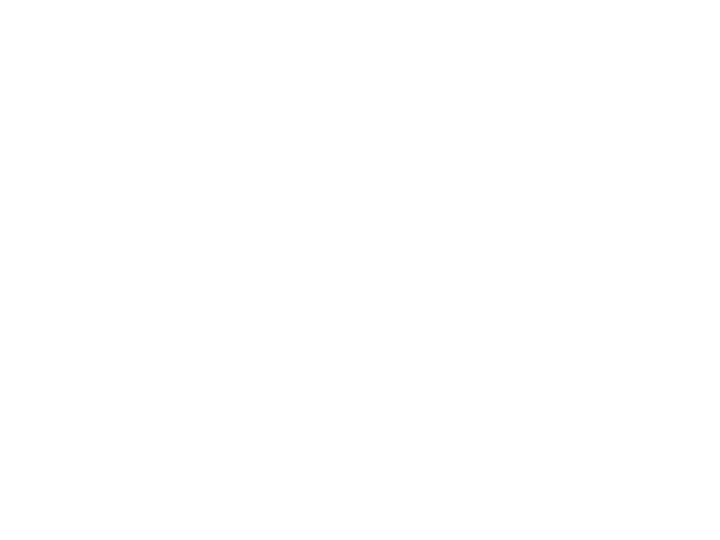

In [24]:
plt.close('all')
fig, ax, anim = visualise_trajectory(pred_trajectory, real_trajectory, TRAJ_ID)
anim.save(os.path.join(path_animations,'visualisation'+str(TRAJ_ID)+'.gif'), writer='imagemagick', fps=60)
plt.close('all')
HTML(anim.to_jshtml())

In [25]:
# Simulator
sim = PushDatasetSimulator(rollout_steps = 50, 
                           step_size = STEP_SIZE)

X_g, Y_g, i_np, _ = sim.get_trajectories(df_te_1, df_te_2, BATCH_SIZE_TE, rigid_graph_from_pos_all)
# Convert trajectories into graphs
traj_X, traj_Y = sim.convert_trajectories(X_g,Y_g)
# Predict trajectory using the model
pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, traj_X, traj_Y)
# Get error in rollout
steps_vel, error_vel = rollout_error(pred_trajectory, real_trajectory)
error_vel = error_vel + 0.000002

steps_pos, error_pos = rollout_error_position(pred_trajectory, real_trajectory)
error_pos = error_pos + 0.000002

<IPython.core.display.Javascript object>


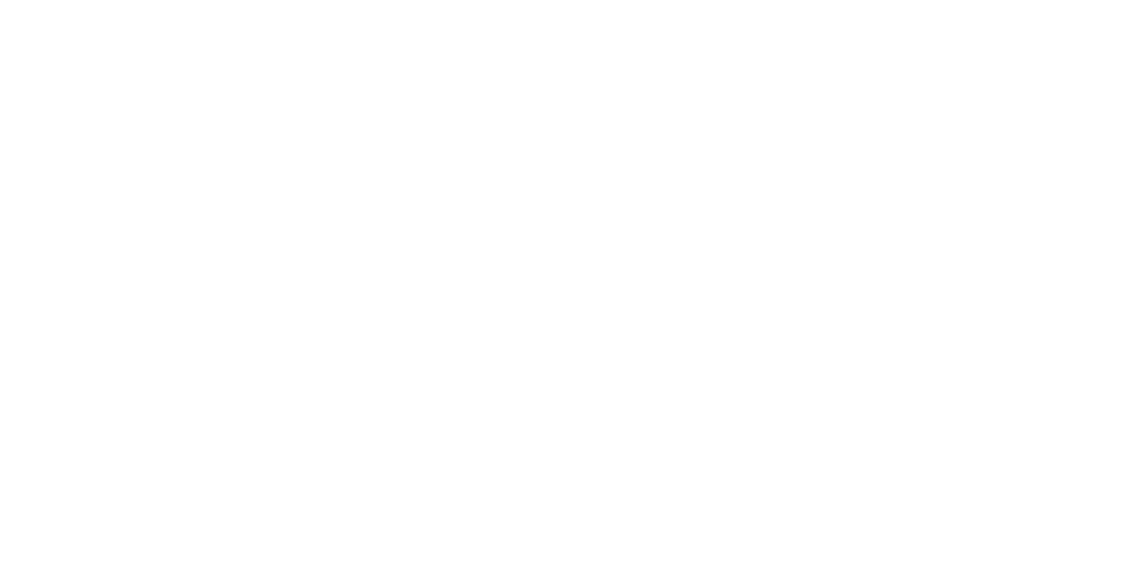

In [26]:
plt.close('all')
fig, ax = rollout_plot(steps_vel, error_vel, path_plots, metric = "Velocity", title = "Rollout Plot")
plt.show()

<IPython.core.display.Javascript object>


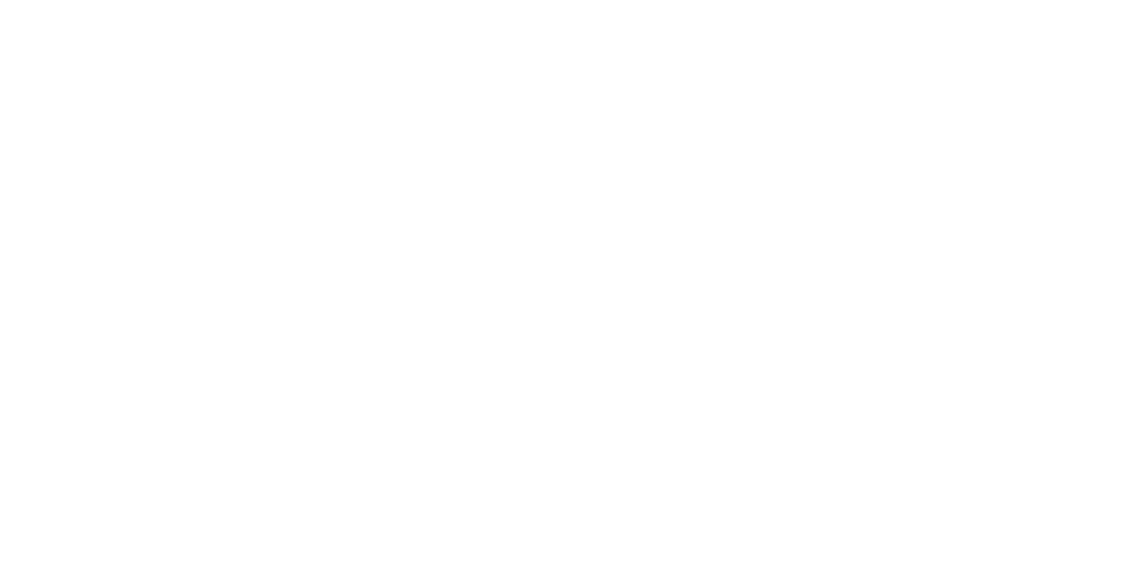

In [27]:
plt.close('all')
fig, ax = rollout_plot_log_scale(steps_vel, error_vel, path_plots, metric = "Velocity", title = "Rollout Plot: Log Scale")
plt.show()

<IPython.core.display.Javascript object>


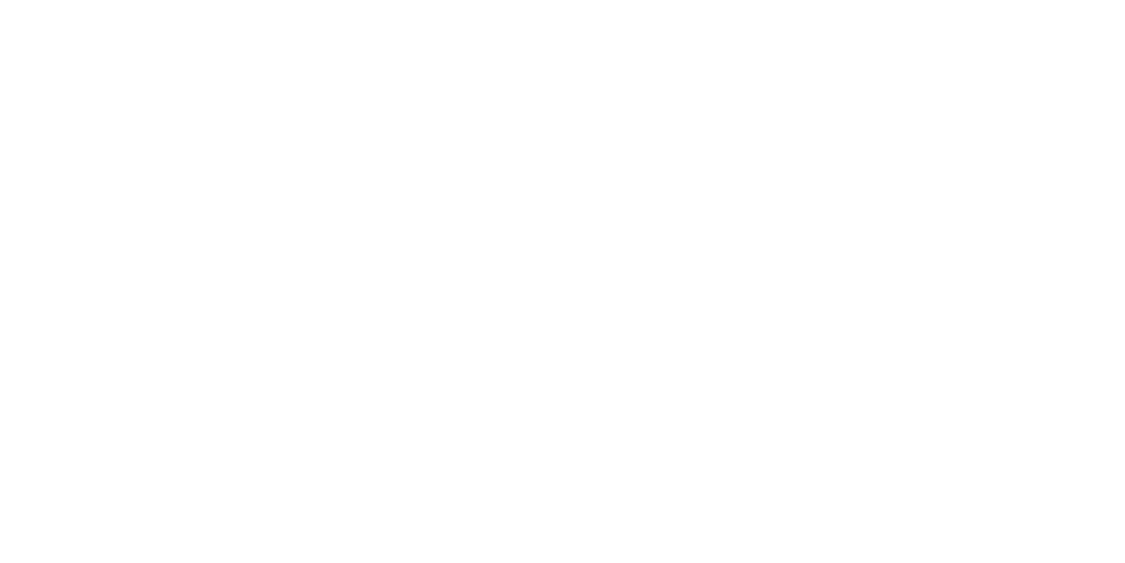

In [28]:
plt.close('all')
fig, ax = rollout_plot(steps_pos, error_pos, path_plots, metric = "Position", title = "Rollout Plot")
plt.show()

<IPython.core.display.Javascript object>


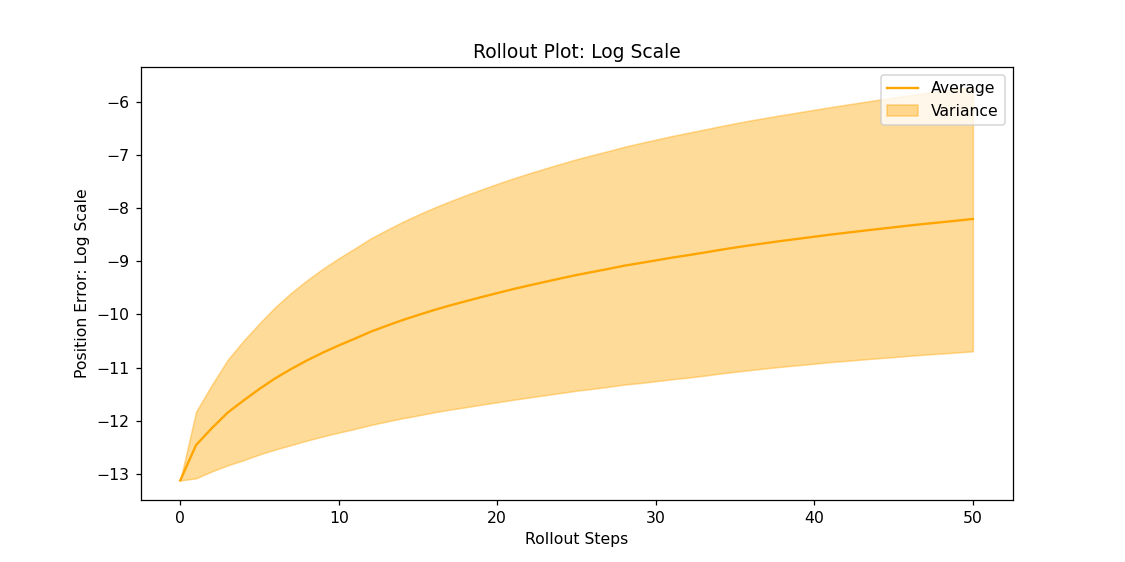

In [29]:
plt.close('all')
fig, ax = rollout_plot_log_scale(steps_pos, error_pos, path_plots, metric = "Position", title = "Rollout Plot: Log Scale")
plt.show()